(Deep) Neural Network approach to the LHCb Ddownstream Tracking T-Seed selection. 
====================
Study description
-------------
This script contains all of my study based on deep and shalow neural networks.  
To construct models I will use [Lasagne](https://github.com/Lasagne/Lasagne) with Theano background.  
All features are normalized. As a hidden layer I assume lasagne.DenseLayer

Study roadmap
----------------
1. Train 1 NN with ReLU nonlinearities  
   1.1  Try different drop-out and regularization layers (both L1 and L2)  
2. Use GridSearchCV to tune number of hidden layer
3. Train second Shallow Neural Network contains 2 hidden layers. Do simillar optimalization steps as prevoiusly. 
4. Train Deep Neural Network (at least 5 hidden layer). 
5. (Optional) Compare the results with models based on [Keras](https://keras.io/)   


The previous models scores to beat:
----------
* kNN **0.787**
* BDT (XGboost) **0.82 **
* Logistic Regresion **0.77**

In [1]:
print("Kernel is alive!")

Kernel is alive!


In [2]:
import root_numpy
import pandas as pd
import numpy
import numpy as np
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import validation_curve

import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, DenseLayer, batch_norm, dropout
from lasagne.regularization import regularize_layer_params, l2, l1

import time

Welcome to ROOTaaS 6.06/02
Couldn't import dot_parser, loading of dot files will not be possible.


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [3]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree, stop=1000000))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [4]:
def add_basic_features(data):
    #abs transformation
    out = data
    out["seed_x"]=numpy.abs(data['seed_x'])
    out["seed_y"]=numpy.abs(data['seed_y'])
    out["seed_tx"]=numpy.abs(data['seed_tx'])
    out["seed_ty"]=numpy.abs(data['seed_ty'])
    #log transformation
    out["seed_p"]= numpy.log(data['seed_p'])
    out["seed_pt"]= numpy.log(data['seed_pt'])
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))
    
    return out

In [5]:
data = add_basic_features(data)
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,pseudo_rapidity,seed_r
0,1.213708,7.841285,7.079410,25,0,12,1263.157617,517.249191,0.524220,0.061572,1.487361,1364.959300
1,1.346112,7.930741,7.093734,25,0,12,1264.522435,99.363473,0.480288,0.009081,1.443802,1268.420312
2,1.627632,8.469986,7.443378,25,0,12,1521.093160,196.064807,0.382802,0.025975,1.370450,1533.677219
3,1.789231,8.556975,7.508752,25,0,12,1563.145597,483.850246,0.369674,0.058753,1.364796,1636.317578
4,1.269238,7.741082,7.132965,24,0,12,1641.727752,411.084316,0.646627,0.054980,1.598503,1692.412576


Scale the features
---------

In [6]:
features = pd.DataFrame(StandardScaler().fit_transform(features))

Train Shallow Neural Network (1NN) 
==================
I try to train the shallow, contains only 1 hidden layer, neural network. 
It contains 800 hidden unit.  
The SNN is created using lasagne framework.  
Then I will try to add some regularization layers (L1 and L2)
I will train this classifier during 15 epoch. 

Split data into train and validation sets
----------------------

In [7]:
y = data['is_true_seed'].values==1
X = features[features.columns[1:]].values.astype(theano.config.floatX)

In [8]:
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=11, train_size=0.5)

In [9]:
input_X = T.matrix('input X')
target_Y = T.ivector('target Y')

Build SNN with 1 hidden layer
------------

In [11]:
n_features =  len(features.columns.values)-1
n_hidden = 800 
p_drop = 0.2

In [12]:
l_in = InputLayer([None, n_features],input_X,'shallow input layer')

l_0 = lasagne.layers.BatchNormLayer(l_in, name="l_0")

l_1 = batch_norm(DenseLayer(l_0,
                num_units=n_hidden,
                name='dense0',
                nonlinearity=lasagne.nonlinearities.rectify))
d_1 = dropout(l_1, p=p_drop)
snn = DenseLayer(d_1,num_units=2,
                name='shallow_dense_out',
                nonlinearity=lasagne.nonlinearities.softmax,)

In [13]:
weights_snn = lasagne.layers.get_all_params(snn,trainable=True)
weights_snn

[l_0.beta,
 l_0.gamma,
 dense0.W,
 dense0_bn.beta,
 dense0_bn.gamma,
 shallow_dense_out.W,
 shallow_dense_out.b]

In [14]:
snn_out = lasagne.layers.get_output(snn)
loss_snn = lasagne.objectives.categorical_crossentropy(snn_out, target_Y).mean()
l2_penalty = regularize_layer_params(l_1, l2) * 1e-3
loss_snn = loss_snn + l2_penalty

In [15]:
updates =lasagne.updates.adadelta(loss_snn,weights_snn)
train_fun = theano.function([input_X,target_Y],[loss_snn,snn_out[:,1]],updates=updates)

In [16]:
det_snn_out = lasagne.layers.get_output(snn,deterministic=True)
det_loss = lasagne.objectives.categorical_crossentropy(det_snn_out,target_Y).mean()
val_fun = theano.function([input_X,target_Y],[det_loss,snn_out[:,1]])

Training loop
--------------
This part of source code contains utilities responsible for training NN based on lasagne.

In [27]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [18]:
train_auc_curve = []
train_acc_curve = []
val_auc_curve = []
val_acc_curve = []

In [28]:
def train_classifier(train_fun, val_fun, num_epochs, batch_size):
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        #print ("start epoch %d"%epoch)
        start_time = time.time()

        train_err = 0
        Ypred_batches = []
        Ytrue_batches = []
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            inputs, targets = batch
            err, y_pred = train_fun(inputs, targets)

            Ypred_batches.append(y_pred)
            Ytrue_batches.append(targets)
            #if train_batches % 100 == 0:
            #    print("train batch %d"%train_batches)

            train_err += err
            train_batches += 1

        Ypred_train = np.concatenate(Ypred_batches)
        Ytrue_train = np.concatenate(Ytrue_batches)
        train_acc = accuracy_score(Ytrue_train, Ypred_train>0.5)
        train_auc = roc_auc_score(Ytrue_train, Ypred_train)

        train_acc_curve.append(train_acc)
        train_auc_curve.append(train_auc)

        print ("start validation")
        # And a full pass over the validation data:
        val_err = 0
        Ypred_batches = []
        Ytrue_batches = []
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
            inputs, targets = batch
            err, y_pred = val_fun(inputs, targets)
            Ypred_batches.append(y_pred)
            Ytrue_batches.append(targets)
            #if val_batches % 100 == 0:
            #    print("val batch %d"%val_batches)

            val_err += err
            val_batches += 1

        Ypred_val = np.concatenate(Ypred_batches)
        Ytrue_val = np.concatenate(Ytrue_batches)
        val_acc = accuracy_score(Ytrue_val, Ypred_val>0.5)
        val_auc = roc_auc_score(Ytrue_val, Ypred_val)

        val_acc_curve.append(val_acc)
        val_auc_curve.append(val_auc)


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  training accuracy:\t\t{:.2f} %".format(
            train_acc * 100))
        print("  training AUCscore:\t\t{:.2f} %".format(
            train_auc * 100))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc  * 100))
        print("  validation AUCscore:\t\t{:.2f} %".format(
            val_auc * 100))

In [52]:
num_epochs = 15
batch_size = 250
train_classifier(train_fun=train_fun, val_fun=val_fun, num_epochs=num_epochs, batch_size=batch_size)

start validation
Epoch 1 of 15 took 164.757s
  training loss:		0.227137
  training accuracy:		93.41 %
  training AUCscore:		71.92 %
  validation loss:		0.216804
  validation accuracy:		93.64 %
  validation AUCscore:		74.02 %
start validation
Epoch 2 of 15 took 179.010s
  training loss:		0.216524
  training accuracy:		93.57 %
  training AUCscore:		74.75 %
  validation loss:		0.220398
  validation accuracy:		93.64 %
  validation AUCscore:		76.17 %
start validation
Epoch 3 of 15 took 164.967s
  training loss:		0.213974
  training accuracy:		93.57 %
  training AUCscore:		75.53 %
  validation loss:		0.205970
  validation accuracy:		93.63 %
  validation AUCscore:		76.98 %
start validation
Epoch 4 of 15 took 162.922s
  training loss:		0.211682
  training accuracy:		93.59 %
  training AUCscore:		76.11 %
  validation loss:		0.209053
  validation accuracy:		93.61 %
  validation AUCscore:		76.91 %
start validation
Epoch 5 of 15 took 162.007s
  training loss:		0.210298
  training accuracy:		93.59 

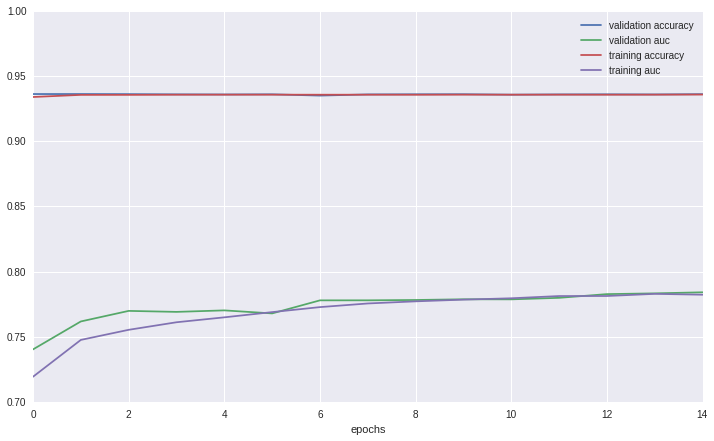

In [53]:
plt.figure(figsize=(12, 7))
plt.plot(val_acc_curve,label='validation accuracy')
plt.plot(val_auc_curve,label='validation auc')
plt.plot(train_acc_curve,label='training accuracy')
plt.plot(train_auc_curve,label='training auc')
plt.xlabel("epochs")
plt.legend(loc='best')
plt.ylim(0.7,1);

In [54]:
print "ROC AUC score - model 1NN with 800 hidden units"
err, y_pred = val_fun(X_val, y_val)
roc_auc_score(y_val, y_pred)

ROC AUC score - model 1NN with 800 hidden units


0.7872207073579176

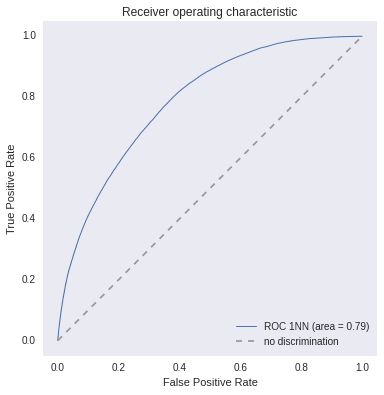

In [55]:
plt.figure(figsize=[6, 6])
err, y_pred = val_fun(X_val, y_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC 1NN (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

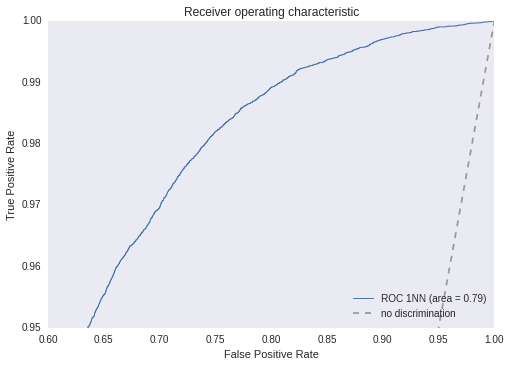

In [56]:
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC 1NN (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.6, 1])
plt.ylim([0.95, 1.])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Train Shallow Neural Network (2NN) 
======
I take a simple NN with 2 hidden layers:
* Layers must contain 800 hidden units each
* Layers must use **relu** nonlinearity
* Dropout probablilty set to 0.2

Above structure can be optimized, but right now I need to make it work

The network parameters
------

In [10]:
n_features =  len(features.columns.values)-1
n_hidden = 800 
p_drop = 0.2

In [11]:
l_2nn_in = InputLayer([None, n_features],input_X,'shallow input layer')

l_2nn_0 = lasagne.layers.BatchNormLayer(l_2nn_in, name="l_2nn_0")

l_2nn_1 = batch_norm(DenseLayer(l_2nn_0,
                num_units=n_hidden,
                name='dense0',
                nonlinearity=lasagne.nonlinearities.rectify))
d_2nn_1 = dropout(l_2nn_1, p=p_drop)

l_2nn_2 = batch_norm(DenseLayer(d_2nn_1,
                num_units=n_hidden,
                name='dense1',
                nonlinearity=lasagne.nonlinearities.rectify))
d_2nn_2 = dropout(l_2nn_2, p=p_drop)
snn_2nn = DenseLayer(d_2nn_2,num_units=2,
                name='2nn_dense_out',
                nonlinearity=lasagne.nonlinearities.softmax,)

In [ ]:
Theano.gcc.cxxflags=-march=avx
weights_snn_2nn = lasagne.layers.get_all_params(snn_2nn,trainable=True)
snn_2nn_out = lasagne.layers.get_output(snn_2nn)

loss_snn_2nn = lasagne.objectives.categorical_crossentropy(snn_2nn_out, target_Y).mean()
l2_2nn_penalty = regularize_layer_params([l_2nn_1, l_2nn_2], l2) * 1e-3
loss_snn_2nn = loss_snn_2nn + l2_2nn_penalty

updates_2nn =lasagne.updates.adadelta(loss_snn_2nn,weights_snn_2nn)
train_fun_2nn = theano.function([input_X,target_Y],[loss_snn_2nn,snn_2nn_out[:,1]],updates=updates_2nn)

det_snn_2nn_out = lasagne.layers.get_output(snn_2nn,deterministic=True)
det_loss_2nn = lasagne.objectives.categorical_crossentropy(det_snn_2nn_out,target_Y).mean()
val_fun_2nn = theano.function([input_X,target_Y],[det_loss_2nn,snn_2nn_out[:,1]])

In [ ]:
train_auc_curve = []
train_acc_curve = []
val_auc_curve = []
val_acc_curve = []

num_epochs = 15
batch_size = 250

train_classifier(train_fun=train_fun_2nn, val_fun=val_fun_2nn, num_epochs=num_epochs, batch_size=batch_size)

Training the DNN is not possible without GPU cluster. 
================ 
I still waiting for access to it. 